In [1]:
from tensorflow.keras.datasets import fashion_mnist
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout, Lambda
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import RMSprop
# load datasets
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
# normalization
train_images = train_images / 255.
test_images = test_images / 255.

4422102/4422102 [==============================] - 0s 0us/step


In [3]:
def create_pairs(x, y):
  pairs = []
  labels = []
  digit_indices = [np.where(y == i)[0] for i in range(10)]
  n = min([len(digit_indices[d]) for d in range(10)]) - 1
  for d in range(10):
    for i in range(n):
      z1, z2 = digit_indices[d][i], digit_indices[d][i+1]
      pairs += [[x[z1], x[z2]]]
      inc = random.randrange(1, 10)
      dn = (d + inc) % 10
      z1, z2 = digit_indices[d][i], digit_indices[dn][i]
      pairs += [[x[z1], x[z2]]]
      labels += [1, 0]
  return np.array(pairs), np.array(labels).astype('float32')
tr_pairs, tr_y = create_pairs(train_images, train_labels)
ts_pairs, ts_y = create_pairs(test_images, test_labels)
print(np.shape(tr_pairs))
print(np.shape(ts_pairs))

(119980, 2, 28, 28)
(19980, 2, 28, 28)


<ipython-input-4-ca5c70fe910a>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


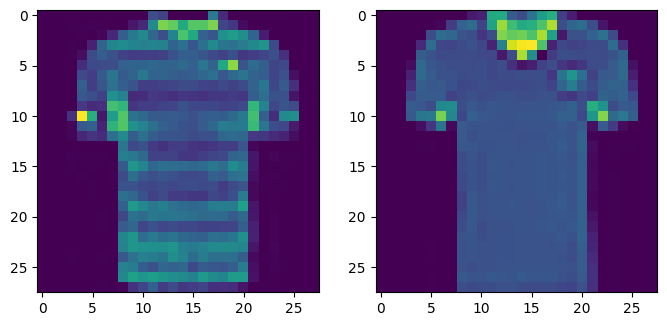

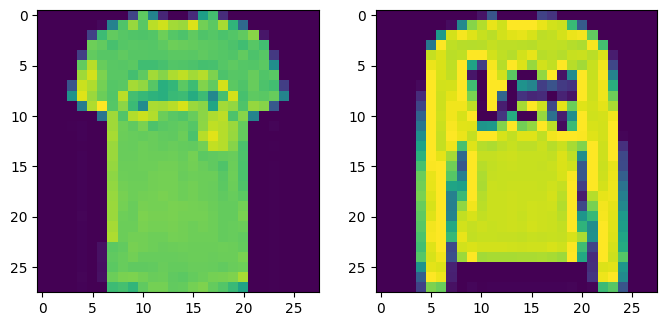

In [4]:
def show_image(image1, image2):
  plt.figure(figsize=(8, 4))
  plt.grid(False)
  plt.subplot(1,2,1)
  plt.imshow(image1)
  plt.subplot(1,2,2)
  plt.imshow(image2)
  plt.show()
show_image(ts_pairs[4][0], ts_pairs[4][1])
show_image(ts_pairs[1][0], ts_pairs[1][1])

In [6]:
def euclidean_distance(vects):
  x, y = vects
  sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
  return tf.math.sqrt(tf.math.maximum(sum_square, 1e-7))

In [7]:
def eucl_dist_output_shape(shapes):
  shape1, shape2 = shapes
  return (shape1[0], 1)

In [8]:
def init_base_network():
  input = Input(shape=(28,28,))
  x = Flatten()(input)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.1)(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.1)(x)
  x = Dense(128, activation='relu')(x)
  return Model(inputs=input, outputs=x)

In [9]:
base_network = init_base_network()

input_a = Input(shape=(28,28,))
input_b = Input(shape=(28,28,))

vect_output_a = base_network(input_a)
vect_output_b = base_network(input_b)


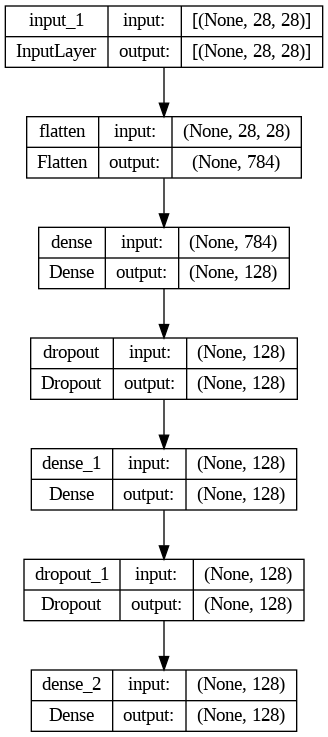

In [11]:
plot_model(base_network, show_shapes=True, show_layer_names=True)

In [12]:
output = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])

In [13]:
model = Model([input_a, input_b], output)

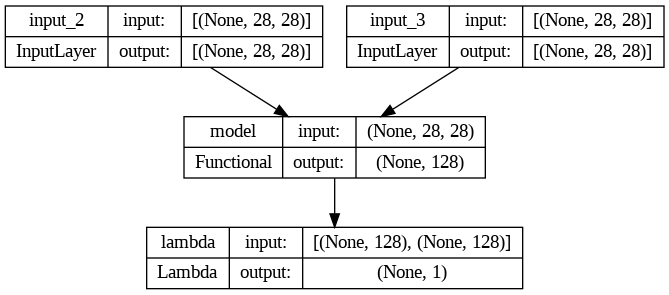

In [14]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [15]:
def contrastive_loss_with_margin(margin):
  def contrastive_loss(y_true, y_pred):
    square_pred = tf.math.square(y_pred)
    margin_square = tf.math.square(tf.math.maximum(margin - y_pred, 0))
    return tf.math.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)
  return contrastive_loss

In [16]:
rms = RMSprop()
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms)
history = model.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_y, epochs=20, batch_size=128,
validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y))

Epoch 1/20
938/938 [==============================] - 10s 5ms/step - loss: 0.1124 - val_loss: 0.0907
Epoch 2/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0817 - val_loss: 0.0793
Epoch 3/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0740 - val_loss: 0.0746
Epoch 4/20
938/938 [==============================] - 5s 5ms/step - loss: 0.0691 - val_loss: 0.0713
Epoch 5/20
938/938 [==============================] - 5s 6ms/step - loss: 0.0658 - val_loss: 0.0687
Epoch 6/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0634 - val_loss: 0.0664
Epoch 7/20
938/938 [==============================] - 4s 5ms/step - loss: 0.0612 - val_loss: 0.0681
Epoch 8/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0593 - val_loss: 0.0659
Epoch 9/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0583 - val_loss: 0.0638
Epoch 10/20
938/938 [==============================] - 4s 5ms/step - loss: 0.0569 - val_loss: 0.064

In [17]:
def compute_accuracy(y_true, y_pred):
  pred = y_pred.ravel() < 0.5
  return np.mean(pred == y_true)
loss = model.evaluate([ts_pairs[:,0],ts_pairs[:,1]], ts_y)
y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
train_accuracy = compute_accuracy(tr_y, y_pred_train)
y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])
test_accuracy = compute_accuracy(ts_y, y_pred_test)
print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

625/625 [==============================] - 1s 2ms/step
Loss = 0.06341498345136642, Train Accuracy = 0.9412568761460244 Test Accuracy = 0.9143643643643644
